In [12]:

import matplotlib.pyplot as plt
import numpy as np
import os, cv2, sys
import time
sys.path.append("..")
from models.yolo_models import get_yolo
%matplotlib inline

In [13]:

anchors = np.array([[53.57159857, 42.28639429], [29.47927551, 51.27168234], [37.15496912, 26.17125211]])
obj_thresh=0.1
nms_thresh=0.25
nb_box=3
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def bbox_iou(box1, box2):
    
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

In [14]:

IMAGE_H, IMAGE_W = 4928//2, 7360//2
#IMAGE_H, IMAGE_W = 4928, 7360
model = get_yolo(IMAGE_W,IMAGE_H)

model.load_weights('../weights/wb_yolo.h5')

In [15]:
image_dir = '../../data/2015/'
image_name = image_dir + 'SWC1077.JPG'
img = cv2.imread(image_name)#1077.JPG') #1149.JPG')

img = img[0:IMAGE_H, 0:IMAGE_W,:]
input_image = cv2.resize(img, (IMAGE_W, IMAGE_H))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)


In [16]:
startall = time.time()

netout = model.predict(input_image)[0]

grid_h, grid_w = netout.shape[:2]
netout = netout.reshape(grid_h,grid_w,nb_box,-1)

# convert from raw output
netout[..., :2]  = _sigmoid(netout[..., :2])
netout[..., 4:]  = _sigmoid(netout[..., 4:])
netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]

# process the coordinates
x = np.linspace(0, grid_w-1, grid_w)
y = np.linspace(0, grid_h-1, grid_h)

xv,yv = np.meshgrid(x, y)
xv = np.expand_dims(xv, -1)
yv = np.expand_dims(yv, -1)
xpos =(np.tile(xv, (1,1,3))+netout[...,0]) * IMAGE_W / grid_w 
ypos =(np.tile(yv, (1,1,3))+netout[...,1]) * IMAGE_H / grid_h
wpos = np.exp(netout[...,2])
hpos = np.exp(netout[...,3])


for b in range(nb_box):
    wpos[...,b] *= anchors[b,0]
    hpos[...,b] *= anchors[b,1]

objectness = netout[...,5]

# select only objects above threshold
indexes = objectness > obj_thresh


new_boxes = np.column_stack((xpos[indexes]-wpos[indexes]/2, \
                             ypos[indexes]-hpos[indexes]/2, \
                             xpos[indexes]+wpos[indexes]/2, \
                             ypos[indexes]+hpos[indexes]/2, \
                             objectness[indexes]))

# do nms 
sorted_indices = np.argsort(-new_boxes[:,4])
boxes=new_boxes.tolist()

for i in range(len(sorted_indices)):
    index_i = sorted_indices[i]

    if new_boxes[index_i,4] == 0: continue

    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        if bbox_iou(boxes[index_i][0:4], boxes[index_j][0:4]) >= nms_thresh:
            new_boxes[index_j,4] = 0

new_boxes = new_boxes[new_boxes[:,4]>0]
end = time.time()
print('all', end - startall)


all 2.9287514686584473


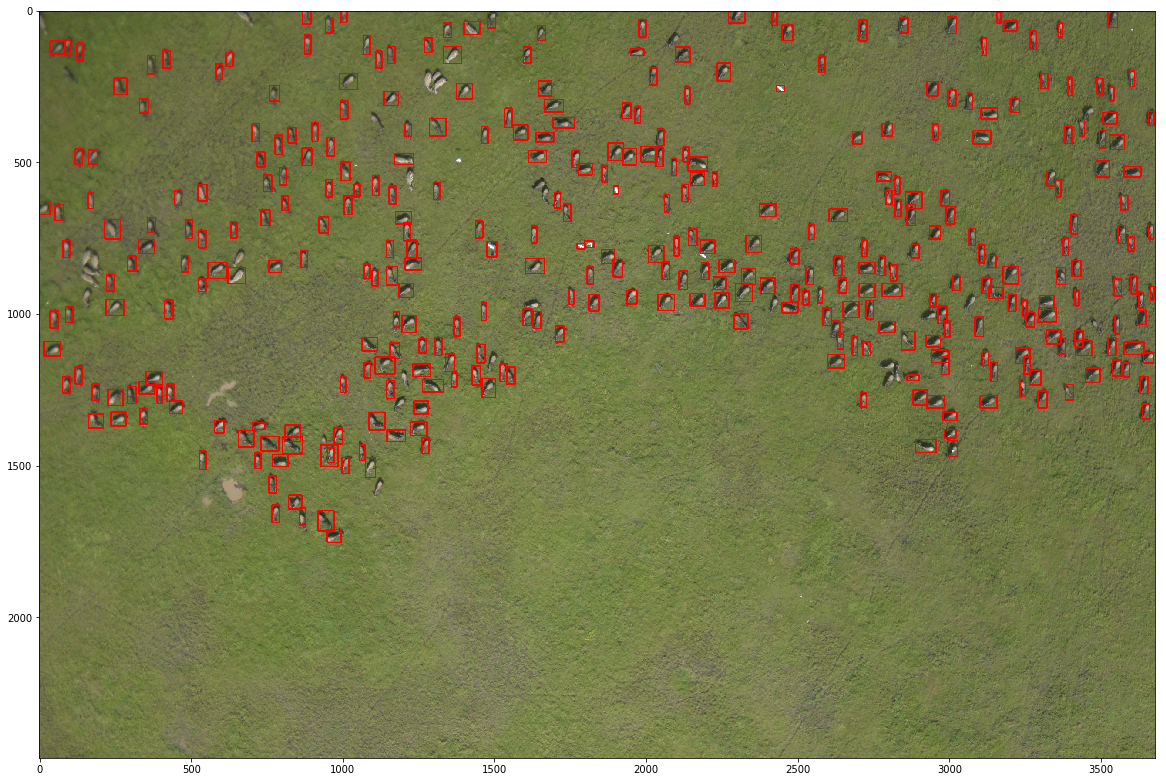

In [17]:


img = cv2.imread(image_name)#1077.JPG') #1149.JPG')


image = img[0:IMAGE_H, 0:IMAGE_W,:]

for box in new_boxes:
    xmin  = int((box[0]))
    xmax  = int((box[2]))
    ymin  = int((box[1]))
    ymax  = int((box[3]))

    cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,255), 3)
plt.figure(figsize=(20,20))
plt.imshow(image[:,:,::-1])
plt.show()


In [18]:
img = cv2.imread(image_name)#1077.JPG') #1149.JPG')

In [19]:
img.shape

(4912, 7360, 3)

In [20]:
4912/32


153.5

In [21]:
len(new_boxes)

350